In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import GMM, BraninCurrin

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cpu"),
}

In [3]:
# define problem
# botorch_problem = GMM(negate=True).to(**tkwargs)
botorch_problem = BraninCurrin(negate=True).to(**tkwargs)
# botorch_problem.ref_point = torch.tensor([0., 0.], **tkwargs)

In [4]:
def plot_objective(problem, X_obs, y_obs, batch_size, num_samples: int = 200):
    pareto = is_non_dominated(y_obs)
    num_dim = problem.nobjs
    # only plot the first two dimensions
    xx, yy = np.meshgrid(
        np.linspace(
            *problem.bounds[0], 200
        ),
        np.linspace(
            *problem.bounds[1], 200
        ),
    )
    input_data = np.vstack((xx.flatten(), yy.flatten())).T
    z = problem.evaluate_from_numpy(input_data)

    fig = plt.figure(figsize=(5 * (num_dim+1), 5))
    for i in range(num_dim):
        ax = plt.subplot2grid((1, num_dim+1), (0, i))
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')

        # plot functions
        countourset = ax.contourf(
            xx,
            yy,
            z[:, i].reshape(xx.shape),
        )

        # plot observations
        ax.scatter(*X_obs[:-batch_size].T, s=10, color='tab:red')
        ax.scatter(*X_obs[-batch_size:].T, s=50, marker="*", color='tab:orange')

        cax.grid(False)  # just to remove the warning
        clb = fig.colorbar(countourset, cax=cax)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f"objective {i+1}")
        clb.ax.set_title('z')

    ax_pareto = plt.subplot2grid((1, num_dim + 1), (0, num_dim))
    ax_pareto.scatter(*y_obs[~pareto].T, color='tab:blue', alpha=0.3, s=10)

    idx = np.argsort(y_obs[pareto][:, 0])
    ax_pareto.plot(*y_obs[pareto][idx].T, color='tab:red', label='approximated pareto front')
    ax_pareto.scatter(*y_obs[pareto][idx].T, color='tab:red', s=10)
    ax_pareto.scatter(*problem.function.ref_point.cpu().t(), color='tab:red', marker='x', label='refence point')
    ax_pareto.set_title("pareto front")
    ax_pareto.legend()
    plt.tight_layout()

In [5]:
def generate_initial_data(problem, n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x, train_obj

In [6]:
init_x, init_y = generate_initial_data(botorch_problem, n=10)

In [7]:
from platypus import NSGAII, Problem, Real, Solution
from platypus.core import _convert_constraint, FixedLengthArray

# pymoo problem
def get_platypus_problem(problem):
    class MyProblem(Problem):
        def __init__(self):
            super().__init__(
                nvars=problem.dim,
                nobjs=problem.num_objectives,
                nconstrs=len(problem.ref_point),
                function=botorch_problem,
            )
            self.types[:] = [Real(*bound) for bound in problem.bounds.numpy().T]
            self.directions[:] = Problem.MAXIMIZE
            self.constraints = _convert_constraint([f">={pt}" for pt in botorch_problem.ref_point])

        @property
        def bounds(self):
            return problem.bounds.numpy().T
        
        def evaluate(self, solution):
            x = solution.variables
            solution.objectives[:] = problem(torch.tensor(x, **tkwargs)).tolist()
            solution.constraints[:] = solution.objectives[:]

        def evaluate_from_numpy(self, x):
            return problem(torch.tensor(x, **tkwargs)).numpy()

    return MyProblem()

problem = get_platypus_problem(botorch_problem)

In [10]:
from platypus.config import default_variator

batch_size = 5
X_obs, y_obs = generate_initial_data(botorch_problem, n=5)

algorithm = NSGAII(problem, population_size=batch_size, archive=[])

if algorithm.nfe == 0:
    algorithm.population = []
    for x, y in zip(X_obs, y_obs):
        solution = Solution(problem)
        solution.variables = x.tolist()
        solution.objectives = y.tolist()
        algorithm.population.append(solution)

    if algorithm.archive is not None:
        algorithm.archive += algorithm.population

    if algorithm.variator is None:
        algorithm.variator = default_variator(algorithm.problem)

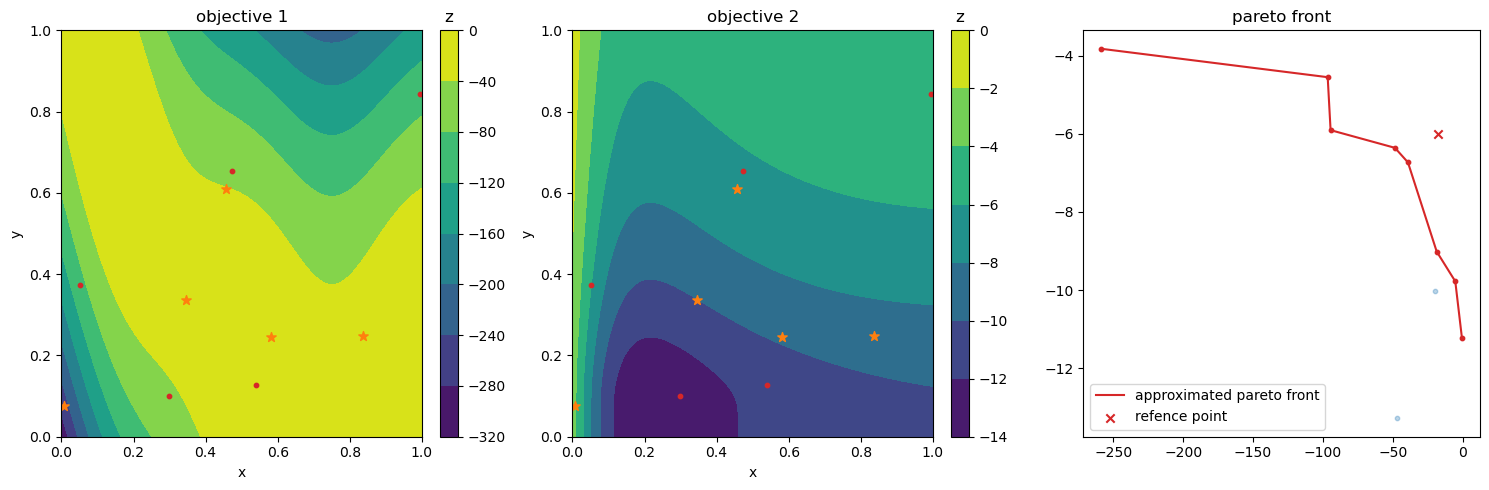

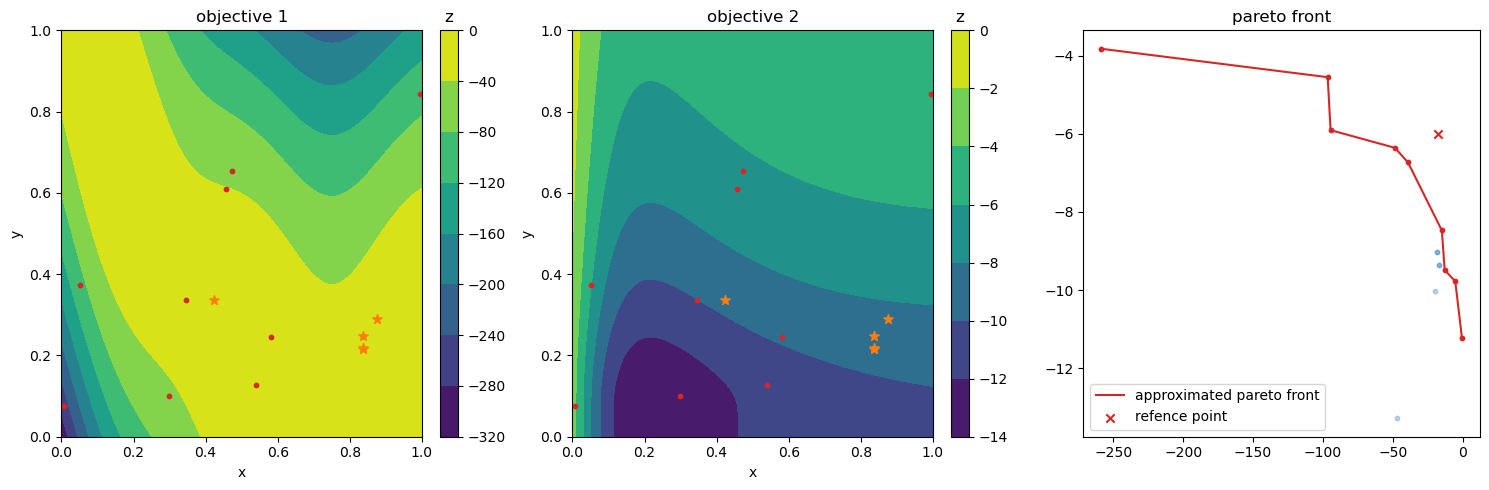

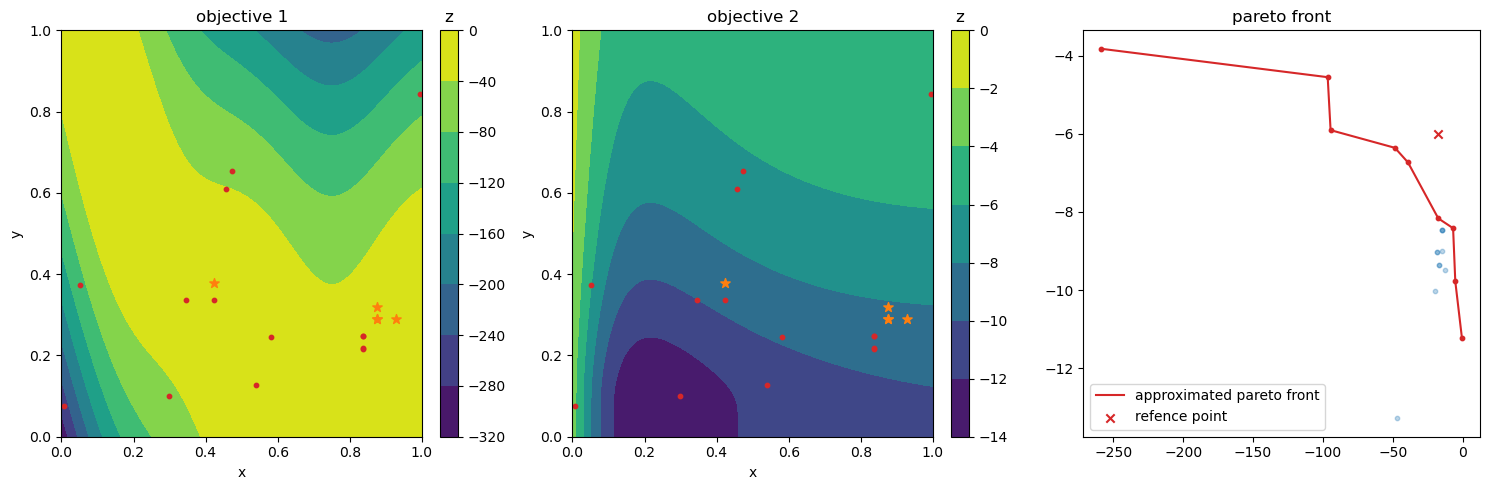

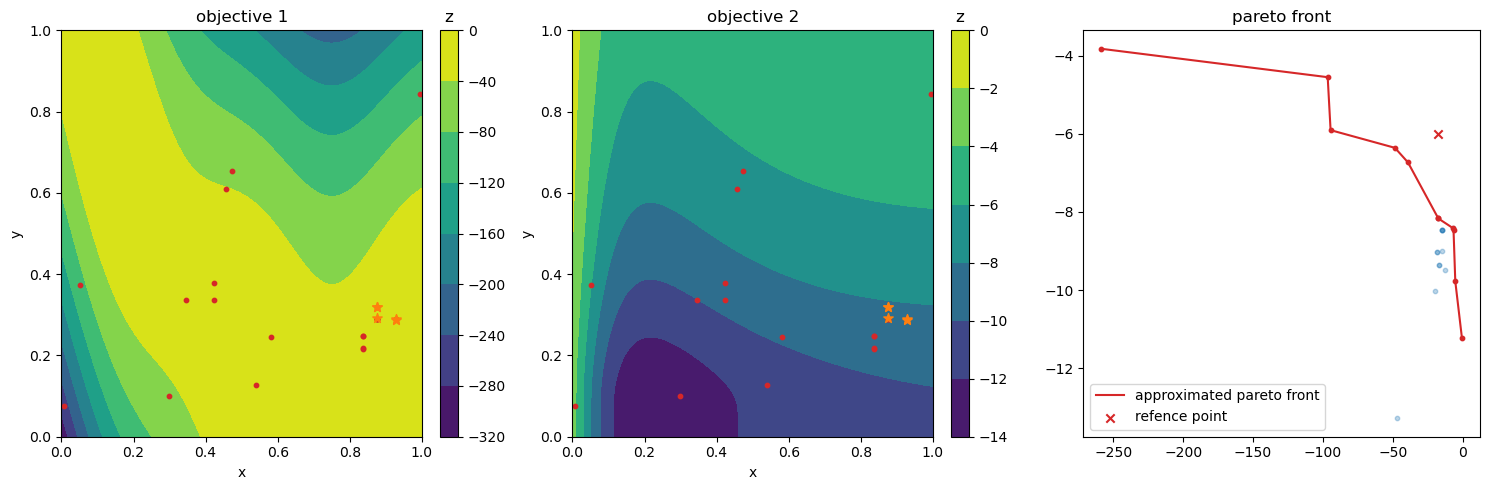

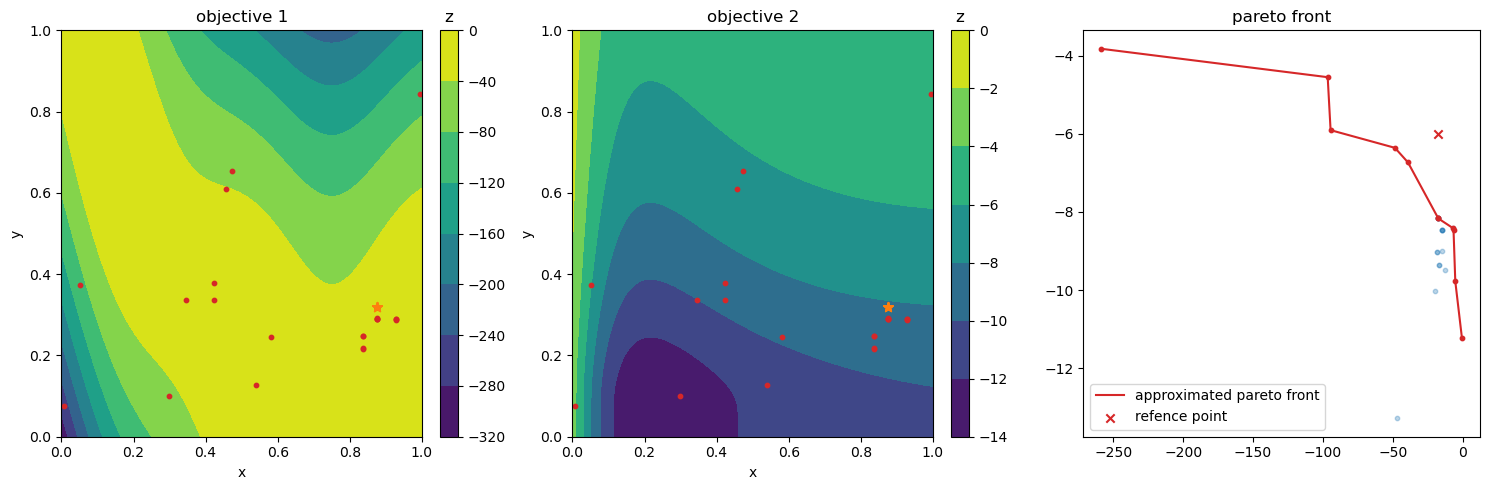

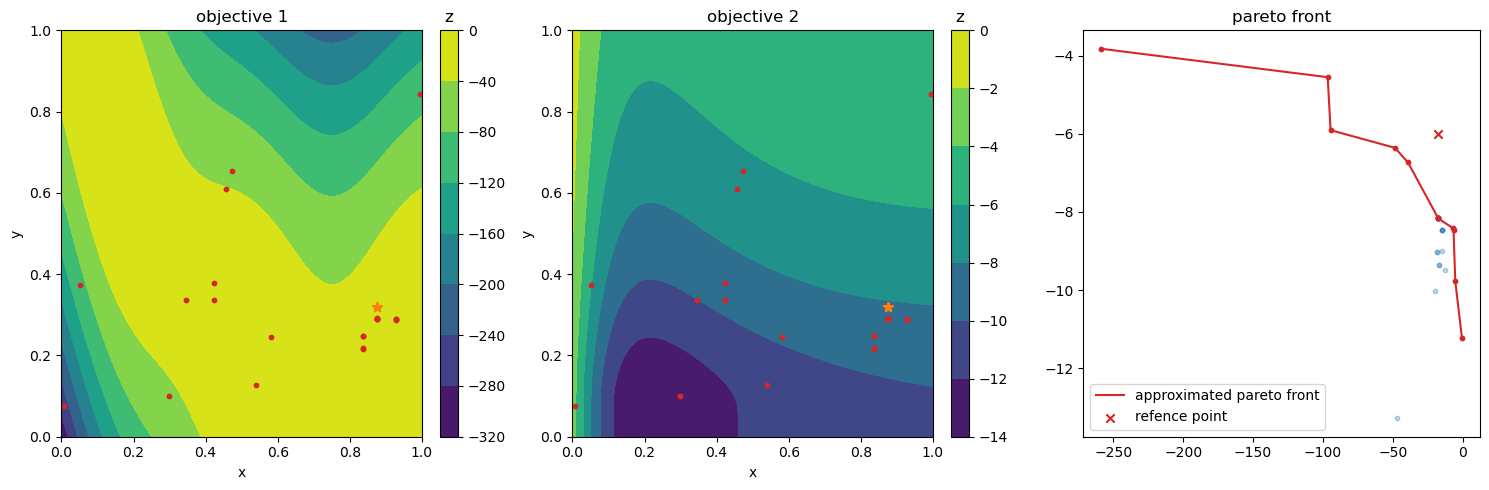

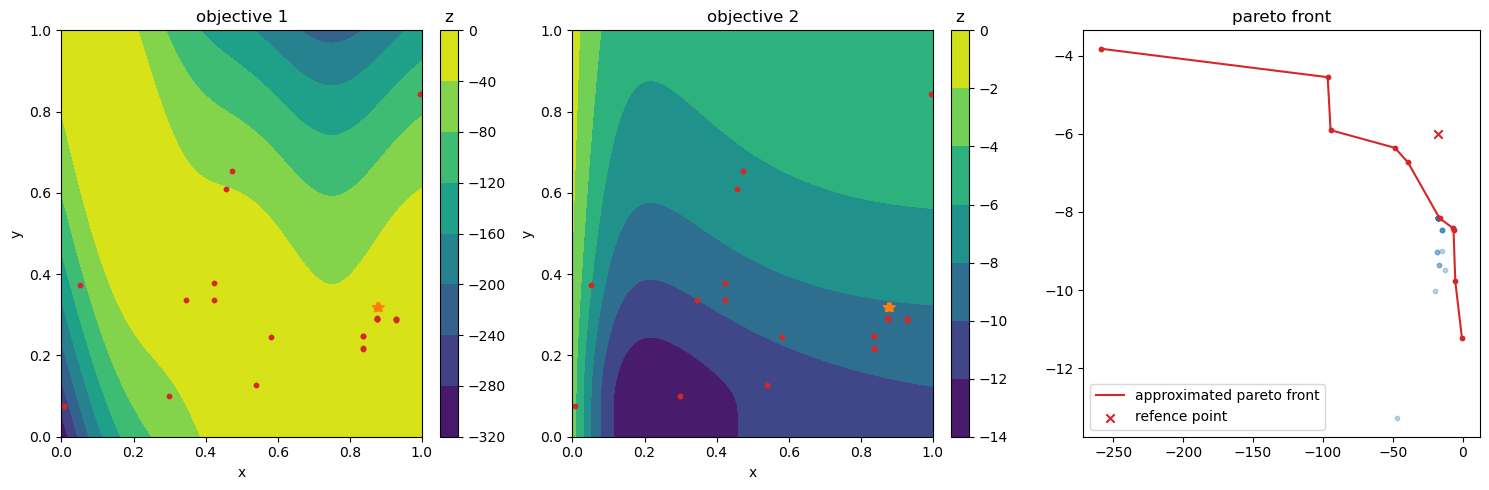

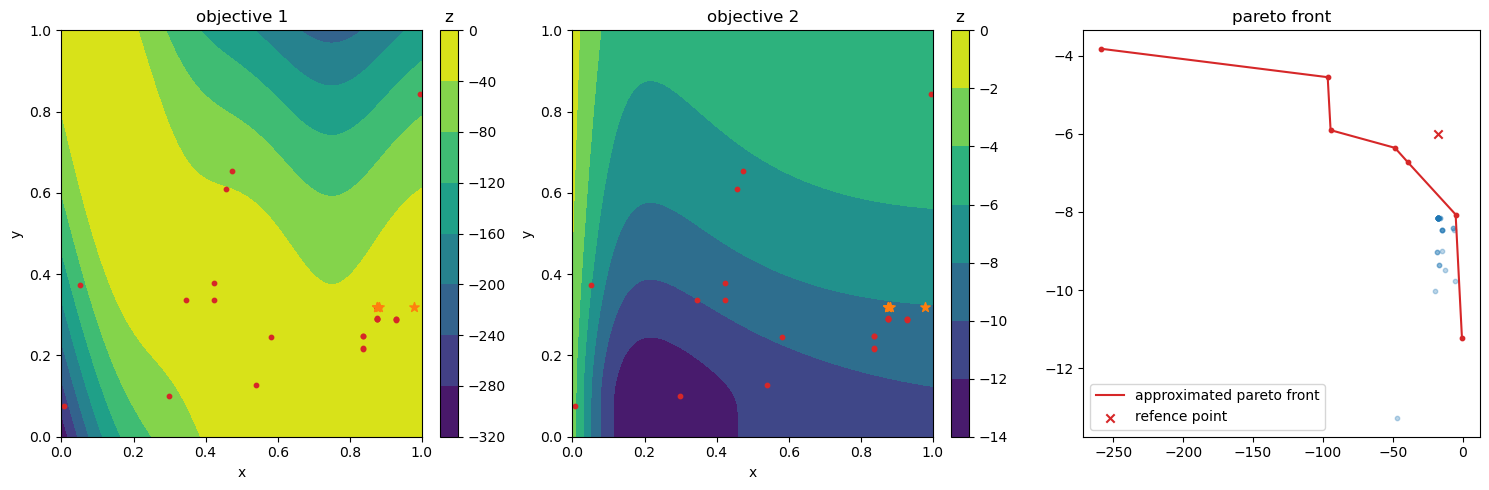

In [ ]:
for _ in range(10):
    algorithm.step()
    X_obs = torch.tensor([r.variables for r in algorithm.archive])
    y_obs = torch.tensor([r.objectives for r in algorithm.archive])
    plot_objective(problem, X_obs, y_obs, batch_size=batch_size)
    plt.show()